In [56]:
# -*- coding=UTF-8 -*-
import os, os.path as osp
import sys
from functools import reduce
import itertools
import time
import seaborn as sns
import copy
from pathlib import Path
from collections import defaultdict
import numpy as np
import cv2
from functools import partial
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, cohen_kappa_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [57]:
def log(*args, **kwargs):
   print(f'{time.strftime("%Y-%m-%d %H:%M:%S")}] ', *args, **kwargs)

In [58]:
task_name = "早期肠癌ML"

# random seed

seed = 10482
batch_size = 8
test_size = 0.84
kfold = 5

max_epoch = 36

save_dir_name1 = "paper_produce_model"
save_dir_name = osp.join(save_dir_name1, task_name, "20230109")
save_dir_name = osp.abspath(save_dir_name)
os.makedirs(save_dir_name, exist_ok=True)
save_dir_name


'Y:\\病理中心-结直肠癌患者淋巴结转移预测\\project\\Lymph_node_metastasisV2\\code\\paper_produce_model\\早期肠癌ML\\20230109'


# 机器学习

In [59]:
ori_lymph_data_df = pd.read_csv(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\编码后数据202303011509.csv")
ori_lymph_data_df["文件名"] =  ori_lymph_data_df["病理号"].apply(lambda f: osp.basename(osp.dirname(f)))
ori_lymph_data_df.head(30)

,Unnamed: 0,Unnamed: 0.1,病理号,性别,年龄,大小,宽度,深度,面积,脉管,...,部位_4,部位_5,肉眼类型_0,肉眼类型_1,分级_0,分级_1,分级_2,分级_3,分级_4,文件名
0,0,s1,GR2016-00073,1,52,20,3.0,2.0,2.0,1,...,0,0,0,1,1,0,0,0,0,
1,1,s2,GR2016-00077,0,67,25,2.0,3.0,2.0,0,...,0,0,0,1,0,0,1,0,0,
2,2,s3,GR2016-00165,1,72,15,1.0,2.0,0.0,1,...,0,0,0,1,0,0,1,0,0,
3,3,s4,GR2016-00446,0,79,25,3.0,3.0,4.0,1,...,0,0,1,0,0,0,1,0,0,
4,4,s5,GR2016-01080,1,67,26,1.0,0.0,0.0,0,...,0,0,0,1,0,0,1,0,0,
5,5,s6,GR2016-02589,0,60,40,3.0,2.0,2.0,0,...,0,0,0,1,0,0,1,0,0,
6,6,s7,GR2016-03231,1,81,11,2.0,1.0,0.0,0,...,0,0,1,0,0,0,1,0,0,
7,7,s8,GR2016-03674,0,70,15,3.0,2.0,2.0,0,...,0,0,0,1,0,0,1,0,0,
8,8,s9,GR2016-05046,1,59,20,0.0,0.0,0.0,0,...,1,0,1,0,0,0,1,0,0,
9,9,s10,GR2016-06569,1,48,15,1.0,0.0,0.0,1,...,0,0,1,0,0,0,1,0,0,


In [60]:
lymph_data_df = ori_lymph_data_df.copy()
log(len(lymph_data_df))
lymph_data_df.head(1)

2023-05-23 19:20:06]  651


,Unnamed: 0,Unnamed: 0.1,病理号,性别,年龄,大小,宽度,深度,面积,脉管,...,部位_4,部位_5,肉眼类型_0,肉眼类型_1,分级_0,分级_1,分级_2,分级_3,分级_4,文件名
0,0,s1,GR2016-00073,1,52,20,3.0,2.0,2.0,1,...,0,0,0,1,1,0,0,0,0,


In [61]:
lymph_data_df[~lymph_data_df.isna()]

,Unnamed: 0,Unnamed: 0.1,病理号,性别,年龄,大小,宽度,深度,面积,脉管,...,部位_4,部位_5,肉眼类型_0,肉眼类型_1,分级_0,分级_1,分级_2,分级_3,分级_4,文件名
0,0,s1,GR2016-00073,1,52,20,3.0,2.0,2.0,1,...,0,0,0,1,1,0,0,0,0,
1,1,s2,GR2016-00077,0,67,25,2.0,3.0,2.0,0,...,0,0,0,1,0,0,1,0,0,
2,2,s3,GR2016-00165,1,72,15,1.0,2.0,0.0,1,...,0,0,0,1,0,0,1,0,0,
3,3,s4,GR2016-00446,0,79,25,3.0,3.0,4.0,1,...,0,0,1,0,0,0,1,0,0,
4,4,s5,GR2016-01080,1,67,26,1.0,0.0,0.0,0,...,0,0,0,1,0,0,1,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,646,en200,GR21-05120,1,65,22,1.0,0.0,0.0,0,...,0,0,1,0,0,0,1,0,0,
647,647,en6,GR2019-15326,0,71,23,3.0,0.0,0.0,1,...,0,0,0,1,0,0,1,0,0,
648,648,en25,GR2018-2713,1,60,30,2.0,NaN,NaN,1,...,0,0,0,1,1,0,0,0,0,
649,649,en40,GR2018-5626,1,52,20,2.0,1.0,1.0,1,...,0,0,0,1,0,0,1,0,0,


In [62]:
lymph_data_df = lymph_data_df.applymap(lambda v: v if isinstance(v, str) else (-1 if np.isnan(v) else v))

In [63]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [64]:
Y_GT_neg_num = np.sum(lymph_data_df["LNM"] == 1)
sorted_lymph_data_df = lymph_data_df.sort_values("LNM")
Y_GT_neg = sorted_lymph_data_df[:Y_GT_neg_num]
Y_GT_pos = sorted_lymph_data_df.iloc[Y_GT_neg_num:].sample(n=Y_GT_neg_num, random_state=seed)
balance_lymph_data_df = pd.concat([Y_GT_neg, Y_GT_pos])
balance_lymph_data_df.reset_index(drop=True, inplace=True)
balance_lymph_data_df.sample(frac=1, random_state=seed).reset_index(drop=True)
balance_lymph_data_df.head()
balance_lymph_data_df = lymph_data_df.copy()

In [65]:
X_INP = balance_lymph_data_df.copy()
X_INP = X_INP.replace(np.inf, -1)

hm_feat_list = [
  "LNM","性别", "年龄","大小","宽度", '深度', '面积', '脉管',
  '出芽', '低分化簇','用途',
    '部位_0','部位_1','部位_2','部位_3','部位_4','部位_5','肉眼类型_0','肉眼类型_1','分级_0','分级_1','分级_2','分级_3','分级_4',"Unnamed: 0"
  ]
X_INP = X_INP[hm_feat_list]
#False
# if False:
# else:
Z_INP = X_INP#.sample(frac=1, random_state=seed).reset_index(drop=True)
X_INP = Z_INP.iloc[:int(test_size*len(Z_INP))].copy()
Y_GT = X_INP.pop("LNM")
X_INP.pop("用途")
MX_INP = Z_INP.iloc[int(test_size*len(Z_INP)):].copy()
MY_GT = MX_INP.pop("LNM")
MX_INP.pop("用途")

546    train
547    train
548    train
549    train
550    train
       ...  
646    train
647    train
648    train
649    train
650    train
Name: 用途, Length: 105, dtype: object

In [66]:
MX_INP["Unnamed: 0"]#.head(50)

546    546
547    547
548    548
549    549
550    550
      ... 
646    646
647    647
648    648
649    649
650    650
Name: Unnamed: 0, Length: 105, dtype: int64

In [68]:
X_INP.describe()

,性别,年龄,大小,宽度,深度,面积,脉管,出芽,低分化簇,部位_0,...,部位_4,部位_5,肉眼类型_0,肉眼类型_1,分级_0,分级_1,分级_2,分级_3,分级_4,Unnamed: 0
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,...,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,0.626374,63.776557,23.135531,2.064103,0.820513,0.950549,0.203297,0.271062,0.230769,0.102564,...,0.029304,0.003663,0.386447,0.613553,0.089744,0.005495,0.869963,0.021978,0.012821,272.500000
std,0.484210,10.769030,11.507474,1.035832,1.004951,1.274784,0.402820,0.580861,0.588768,0.303667,...,0.168812,0.060467,0.487382,0.487382,0.286076,0.073989,0.336652,0.146746,0.112603,157.760895
min,0.000000,26.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,57.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,136.250000
50%,1.000000,65.000000,20.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,272.500000
75%,1.000000,71.000000,30.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,408.750000
max,1.000000,89.000000,85.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,545.000000


In [69]:
Y_GT.value_counts()

0    487
1     59
Name: LNM, dtype: int64

In [70]:
X_INP.keys()

Index(['性别', '年龄', '大小', '宽度', '深度', '面积', '脉管', '出芽', '低分化簇', '部位_0', '部位_1',
       '部位_2', '部位_3', '部位_4', '部位_5', '肉眼类型_0', '肉眼类型_1', '分级_0', '分级_1',
       '分级_2', '分级_3', '分级_4', 'Unnamed: 0'],
      dtype='object')

In [71]:
def transform_data(INP_DATA):
  return pd.DataFrame({
    k: v
    for k, v in zip(INP_DATA.keys(), sklearn.preprocessing.StandardScaler().fit_transform(INP_DATA).T)
  })

X_INP = transform_data(X_INP)
MX_INP = transform_data(MX_INP)


In [72]:
X_INP.describe()

,性别,年龄,大小,宽度,深度,面积,脉管,出芽,低分化簇,部位_0,...,部位_4,部位_5,肉眼类型_0,肉眼类型_1,分级_0,分级_1,分级_2,分级_3,分级_4,Unnamed: 0
count,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,...,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02,5.460000e+02
mean,-1.199692e-16,2.524182e-16,-7.137148e-17,-1.945940e-16,-4.794699e-16,-1.559599e-16,-9.451129e-16,-5.876455e-17,5.347778e-17,-1.754803e-16,...,4.880101e-17,-2.703881e-16,-2.074043e-17,4.066751e-18,3.562474e-16,-2.508677e-16,-9.943206e-17,-4.262972e-16,-6.349215e-17,2.074043e-17
std,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,...,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00,1.000917e+00
min,-1.294786e+00,-3.511105e+00,-2.012322e+00,-2.960821e+00,-1.813205e+00,-1.531506e+00,-5.051459e-01,-4.670839e-01,-3.923121e-01,-3.380617e-01,...,-1.737489e-01,-6.063391e-02,-7.936314e-01,-1.260031e+00,-3.139929e-01,-7.432941e-02,-2.586531e+00,-1.499063e-01,-1.139606e-01,-1.728881e+00
25%,-1.294786e+00,-6.298405e-01,-7.076263e-01,-6.194186e-02,-8.172190e-01,-7.463393e-01,-5.051459e-01,-4.670839e-01,-3.923121e-01,-3.380617e-01,...,-1.737489e-01,-6.063391e-02,-7.936314e-01,-1.260031e+00,-3.139929e-01,-7.432941e-02,3.866183e-01,-1.499063e-01,-1.139606e-01,-8.644407e-01
50%,7.723284e-01,1.137117e-01,-2.727277e-01,-6.194186e-02,1.787666e-01,3.882690e-02,-5.051459e-01,-4.670839e-01,-3.923121e-01,-3.380617e-01,...,-1.737489e-01,-6.063391e-02,-7.936314e-01,7.936314e-01,-3.139929e-01,-7.432941e-02,3.866183e-01,-1.499063e-01,-1.139606e-01,0.000000e+00
75%,7.723284e-01,6.713759e-01,5.970697e-01,9.043511e-01,1.174752e+00,8.239931e-01,-5.051459e-01,-4.670839e-01,-3.923121e-01,-3.380617e-01,...,-1.737489e-01,-6.063391e-02,1.260031e+00,7.936314e-01,-3.139929e-01,-7.432941e-02,3.866183e-01,-1.499063e-01,-1.139606e-01,8.644407e-01
max,7.723284e-01,2.344368e+00,5.380955e+00,2.836937e+00,4.162709e+00,3.179492e+00,1.979626e+00,4.702398e+00,4.707745e+00,2.958040e+00,...,5.755432e+00,1.649242e+01,1.260031e+00,7.936314e-01,3.184785e+00,1.345362e+01,3.866183e-01,6.670832e+00,8.774964e+00,1.728881e+00


In [73]:
def calc_metrics(np_gt_cls, np_scores):
  """
  Returns Acc, AUC, Kappa
  """
  if np_scores.ndim == 2:
    pred_labels = np_scores.argmax(-1)
    np_scores = np_scores[:, 1]
  else:
    pred_labels = (np_scores > 0.5)
  acc_1 = accuracy_score(np_gt_cls, pred_labels)
  try:
    auc_1 = roc_auc_score(np_gt_cls, np_scores)
  except:
    auc_1 = cohen_kappa_score(np_gt_cls, pred_labels)
  kappa_1 = cohen_kappa_score(np_gt_cls, pred_labels)
  return acc_1, auc_1, kappa_1

def get_tn_fp_fn_tp(gt_cls_1, scores_1, thresh):
  zz_labels = scores_1 >= thresh
  tn, fp, fn, tp = confusion_matrix(gt_cls_1, zz_labels, labels=[0, 1]).ravel()
  return tn, fp, fn, tp

def get_thresh_meet_tpr(gt_cls, scores, min_tpr, thresh_min=0.0, thresh_max=1.0, thr_eps=1e-4):
  TPR_1, TNR_1 = [], []
  THRs_1 = np.arange(thresh_min, thresh_max, thr_eps)
  for thr in THRs_1:
    tn, fp, fn, tp = get_tn_fp_fn_tp(gt_cls, scores, thr)
    tpr = tp / gt_cls.sum()
    tnr = tn / (1 - gt_cls).sum()
    TPR_1.append(tpr)
    TNR_1.append(tnr)
  TPR, TNR = np.array(TPR_1), np.array(TNR_1)
  min_tpr_index = (TPR >= min_tpr).sum()-1
  assert (
    min_tpr_index >= 0
  ), "Failed to locate PTC TPR >= {}".format_map(min_tpr)
  return THRs_1, min_tpr_index, TPR, TNR

# 随机森林 特征排序

In [74]:
from sklearn import ensemble
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=99, max_depth=4)

from sklearn.model_selection import StratifiedKFold
est_kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=seed)

est_feat_names = X_INP.keys()
est_feat_values = X_INP.values
est_gt_values = Y_GT.values

diff_acc_list = defaultdict(list)
diff_auc_list = defaultdict(list)
diff_kappa_list = defaultdict(list)

for fold_i, (train_est_indices, valid_est_indices) in enumerate(est_kf.split(est_feat_values, est_gt_values)):
  est_train_X = est_feat_values[train_est_indices]
  est_train_Y = est_gt_values[train_est_indices]
  est_val_X = est_feat_values[valid_est_indices]
  est_val_Y = est_gt_values[valid_est_indices]

  rf.fit(est_train_X, est_train_Y)

  est_acc, est_auc, est_kappa = calc_metrics(est_val_Y, rf.predict(est_val_X))

  for ci in range(est_val_X.shape[-1]):
    c_est_val_X = est_val_X.copy()
    np.random.seed(seed)
    np.random.shuffle(c_est_val_X[:, ci])
    c_est_acc, c_est_auc, c_est_kappa = calc_metrics(est_val_Y, rf.predict(c_est_val_X))
    diff_acc = (est_acc-c_est_acc) / est_acc
    diff_auc = (est_auc-c_est_auc) / est_auc
    diff_kappa = (est_kappa-c_est_kappa) / est_kappa

    diff_acc_list[est_feat_names[ci]].append(np.abs(diff_acc))
    diff_auc_list[est_feat_names[ci]].append(np.abs(diff_auc))
    diff_kappa_list[est_feat_names[ci]].append(np.abs(diff_kappa))

In [75]:
feat_corr = pd.DataFrame({
  k: [np.mean(kacc), np.std(kacc), np.mean(kauc), np.std(kauc), np.mean(kkappa), np.std(kkappa)]
  for (k, kacc), kauc, kkappa in zip(diff_acc_list.items(), diff_auc_list.values(), diff_kappa_list.values())
})

feat_corr = feat_corr.T.rename(
  columns={0: "ACC_MEAN", 1: "ACC_STD",
           2: "AUC_MEAN", 3: "AUC_STD",
           4: "KAPPA_MEAN", 5: "KAPPA_STD"})
feat_corr = feat_corr.sort_values(by="AUC_MEAN", ascending=False)
feat_corr

,ACC_MEAN,ACC_STD,AUC_MEAN,AUC_STD,KAPPA_MEAN,KAPPA_STD
脉管,0.032451,0.018588,0.380393,0.104476,0.903109,0.267208
Unnamed: 0,0.016635,0.016778,0.044269,0.035395,0.265289,0.243269
大小,0.002179,0.006162,0.040387,0.063086,0.045997,0.089258
面积,0.000000,0.000000,0.019520,0.030485,0.025167,0.071183
分级_0,0.000000,0.000000,0.018369,0.031327,0.000000,0.000000
年龄,0.020442,0.013376,0.017517,0.014921,0.426920,0.296485
深度,0.002137,0.006044,0.011521,0.015976,0.038488,0.108860
部位_3,0.000000,0.000000,0.009068,0.016540,0.000000,0.000000
分级_2,0.012239,0.012185,0.007689,0.006446,0.199867,0.177016
出芽,0.008083,0.009040,0.005345,0.004442,0.182375,0.311061


In [76]:
feat_topk = 11
feat_corr_topk = feat_corr.iloc[:, :]
feat_corr_topk

,ACC_MEAN,ACC_STD,AUC_MEAN,AUC_STD,KAPPA_MEAN,KAPPA_STD
脉管,0.032451,0.018588,0.380393,0.104476,0.903109,0.267208
Unnamed: 0,0.016635,0.016778,0.044269,0.035395,0.265289,0.243269
大小,0.002179,0.006162,0.040387,0.063086,0.045997,0.089258
面积,0.000000,0.000000,0.019520,0.030485,0.025167,0.071183
分级_0,0.000000,0.000000,0.018369,0.031327,0.000000,0.000000
年龄,0.020442,0.013376,0.017517,0.014921,0.426920,0.296485
深度,0.002137,0.006044,0.011521,0.015976,0.038488,0.108860
部位_3,0.000000,0.000000,0.009068,0.016540,0.000000,0.000000
分级_2,0.012239,0.012185,0.007689,0.006446,0.199867,0.177016
出芽,0.008083,0.009040,0.005345,0.004442,0.182375,0.311061


In [77]:
good_feat_names = feat_corr_topk.T.keys()
good_feat_names

Index(['脉管', 'Unnamed: 0', '大小', '面积', '分级_0', '年龄', '深度', '部位_3', '分级_2',
       '出芽', '部位_4', '部位_0', '宽度', '低分化簇', '肉眼类型_1', '性别', '部位_2', '分级_3',
       '肉眼类型_0', '部位_5', '分级_1', '部位_1', '分级_4'],
      dtype='object')

In [78]:
filter_X_INP = pd.DataFrame({
  k: X_INP[k].values for k in good_feat_names
})
filter_X_INP

,脉管,Unnamed: 0,大小,面积,分级_0,年龄,深度,部位_3,分级_2,出芽,...,低分化簇,肉眼类型_1,性别,部位_2,分级_3,肉眼类型_0,部位_5,分级_1,部位_1,分级_4
0,1.979626,-1.728881,-0.272728,0.823993,3.184785,-1.094561,1.174752,-0.632456,-2.586531,-0.467084,...,-0.392312,0.793631,0.772328,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
1,-0.505146,-1.722537,0.162171,0.823993,-0.313993,0.299600,2.170738,-0.632456,0.386618,-0.467084,...,-0.392312,0.793631,-1.294786,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
2,1.979626,-1.716192,-0.707626,-0.746339,-0.313993,0.764320,1.174752,-0.632456,0.386618,-0.467084,...,-0.392312,0.793631,0.772328,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
3,1.979626,-1.709848,0.162171,2.394326,-0.313993,1.414928,2.170738,-0.632456,0.386618,-0.467084,...,-0.392312,-1.260031,-1.294786,0.912258,-0.149906,1.260031,-0.060634,-0.074329,-0.184637,-0.113961
4,-0.505146,-1.703503,0.249151,-0.746339,-0.313993,0.299600,-0.817219,-0.632456,0.386618,-0.467084,...,-0.392312,0.793631,0.772328,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,1.979626,1.703503,-0.707626,0.823993,3.184785,-1.373393,1.174752,-0.632456,-2.586531,-0.467084,...,-0.392312,0.793631,-1.294786,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
542,-0.505146,1.709848,-0.272728,-0.746339,-0.313993,1.786704,-0.817219,-0.632456,0.386618,-0.467084,...,-0.392312,-1.260031,0.772328,0.912258,-0.149906,1.260031,-0.060634,-0.074329,-0.184637,-0.113961
543,-0.505146,1.716192,-0.707626,-0.746339,-0.313993,0.113712,-0.817219,-0.632456,0.386618,-0.467084,...,-0.392312,0.793631,0.772328,0.912258,-0.149906,-0.793631,-0.060634,-0.074329,-0.184637,-0.113961
544,-0.505146,1.722537,1.031968,0.038827,-0.313993,-3.511105,0.178767,-0.632456,0.386618,-0.467084,...,-0.392312,0.793631,0.772328,-1.096181,-0.149906,-0.793631,16.492423,-0.074329,-0.184637,-0.113961


In [79]:
def fuse_model(inp_models, index=None):
  if index is not None:
    return inp_models[index]

  class FuseModel(object):
    def __init__(self):
      self.inp_models = inp_models
      return
    def predict(self, x):
      y_list = np.dstack(list(map(lambda m: m.predict(x), self.inp_models)))
      y = np.mean(y_list, axis=-1)
      return y
  return FuseModel()

In [80]:
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn import model_selection as ms

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(Y_GT.value_counts()),
    'num_leaves': 2 ** 3,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 4,
    'learning_rate': 1e-4,
    "min_data_in_leaf": 16,
    'dropout_rate': 0.5,
    'seed': seed,
    'verbose': -1,
  }
from sklearn.model_selection import StratifiedKFold
est_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
model_list = []
est_metrics_dict = dict()
for fold_i, (train_est_indices, valid_est_indices) in enumerate(est_kf.split(filter_X_INP, Y_GT)):
  est_train_X = filter_X_INP.iloc[train_est_indices]
  est_train_Y = Y_GT.iloc[train_est_indices]
  est_val_X = filter_X_INP.iloc[valid_est_indices]
  est_val_Y = Y_GT.iloc[valid_est_indices]

  est_model = lgb.train(
    params,
    train_set=lgb.Dataset(est_train_X, label=est_train_Y),
    valid_sets=lgb.Dataset(est_val_X, label=est_val_Y),
    num_boost_round=100001,
    verbose_eval=200,
    early_stopping_rounds=2000
  )
  est_model.predict = partial(est_model.predict, num_iteration=est_model.best_iteration)
  model_list.append(est_model)
  zz = calc_metrics(est_val_Y, est_model.predict(est_val_X))
  est_metrics_dict[fold_i] = zz
  log("Metrics: {}".format(zz))

Training until validation scores don't improve for 2000 rounds.
[200]	valid_0's multi_logloss: 0.341365
[400]	valid_0's multi_logloss: 0.338509
[600]	valid_0's multi_logloss: 0.335777
[800]	valid_0's multi_logloss: 0.333263
[1000]	valid_0's multi_logloss: 0.330861
[1200]	valid_0's multi_logloss: 0.328623
[1400]	valid_0's multi_logloss: 0.326448
[1600]	valid_0's multi_logloss: 0.324241
[1800]	valid_0's multi_logloss: 0.322093
[2000]	valid_0's multi_logloss: 0.320011
[2200]	valid_0's multi_logloss: 0.317945
[2400]	valid_0's multi_logloss: 0.315975
[2600]	valid_0's multi_logloss: 0.314118
[2800]	valid_0's multi_logloss: 0.312291
[3000]	valid_0's multi_logloss: 0.310686
[3200]	valid_0's multi_logloss: 0.30914
[3400]	valid_0's multi_logloss: 0.307547
[3600]	valid_0's multi_logloss: 0.306059
[3800]	valid_0's multi_logloss: 0.304597
[4000]	valid_0's multi_logloss: 0.303006
[4200]	valid_0's multi_logloss: 0.30156
[4400]	valid_0's multi_logloss: 0.300238
[4600]	valid_0's multi_logloss: 0.298941

[13600]	valid_0's multi_logloss: 0.235654
[13800]	valid_0's multi_logloss: 0.235019
[14000]	valid_0's multi_logloss: 0.234484
[14200]	valid_0's multi_logloss: 0.233911
[14400]	valid_0's multi_logloss: 0.233449
[14600]	valid_0's multi_logloss: 0.232915
[14800]	valid_0's multi_logloss: 0.232375
[15000]	valid_0's multi_logloss: 0.231806
[15200]	valid_0's multi_logloss: 0.2313
[15400]	valid_0's multi_logloss: 0.230853
[15600]	valid_0's multi_logloss: 0.230303
[15800]	valid_0's multi_logloss: 0.229803
[16000]	valid_0's multi_logloss: 0.229397
[16200]	valid_0's multi_logloss: 0.228993
[16400]	valid_0's multi_logloss: 0.228522
[16600]	valid_0's multi_logloss: 0.228057
[16800]	valid_0's multi_logloss: 0.227679
[17000]	valid_0's multi_logloss: 0.227331
[17200]	valid_0's multi_logloss: 0.226897
[17400]	valid_0's multi_logloss: 0.226421
[17600]	valid_0's multi_logloss: 0.226055
[17800]	valid_0's multi_logloss: 0.225672
[18000]	valid_0's multi_logloss: 0.225301
[18200]	valid_0's multi_logloss: 0.2

[14200]	valid_0's multi_logloss: 0.217027
[14400]	valid_0's multi_logloss: 0.216359
[14600]	valid_0's multi_logloss: 0.215623
[14800]	valid_0's multi_logloss: 0.214946
[15000]	valid_0's multi_logloss: 0.214285
[15200]	valid_0's multi_logloss: 0.21358
[15400]	valid_0's multi_logloss: 0.212996
[15600]	valid_0's multi_logloss: 0.212319
[15800]	valid_0's multi_logloss: 0.211625
[16000]	valid_0's multi_logloss: 0.211032
[16200]	valid_0's multi_logloss: 0.210496
[16400]	valid_0's multi_logloss: 0.209887
[16600]	valid_0's multi_logloss: 0.209289
[16800]	valid_0's multi_logloss: 0.208731
[17000]	valid_0's multi_logloss: 0.208222
[17200]	valid_0's multi_logloss: 0.207587
[17400]	valid_0's multi_logloss: 0.206977
[17600]	valid_0's multi_logloss: 0.206476
[17800]	valid_0's multi_logloss: 0.205947
[18000]	valid_0's multi_logloss: 0.205334
[18200]	valid_0's multi_logloss: 0.204805
[18400]	valid_0's multi_logloss: 0.204311
[18600]	valid_0's multi_logloss: 0.203788
[18800]	valid_0's multi_logloss: 0.

[53400]	valid_0's multi_logloss: 0.172881
[53600]	valid_0's multi_logloss: 0.172866
[53800]	valid_0's multi_logloss: 0.17286
[54000]	valid_0's multi_logloss: 0.172838
[54200]	valid_0's multi_logloss: 0.172745
[54400]	valid_0's multi_logloss: 0.172709
[54600]	valid_0's multi_logloss: 0.172739
[54800]	valid_0's multi_logloss: 0.172691
[55000]	valid_0's multi_logloss: 0.172659
[55200]	valid_0's multi_logloss: 0.1726
[55400]	valid_0's multi_logloss: 0.172624
[55600]	valid_0's multi_logloss: 0.172591
[55800]	valid_0's multi_logloss: 0.172537
[56000]	valid_0's multi_logloss: 0.172505
[56200]	valid_0's multi_logloss: 0.172479
[56400]	valid_0's multi_logloss: 0.172464
[56600]	valid_0's multi_logloss: 0.172402
[56800]	valid_0's multi_logloss: 0.172347
[57000]	valid_0's multi_logloss: 0.172289
[57200]	valid_0's multi_logloss: 0.172307
[57400]	valid_0's multi_logloss: 0.17227
[57600]	valid_0's multi_logloss: 0.172202
[57800]	valid_0's multi_logloss: 0.172187
[58000]	valid_0's multi_logloss: 0.172

[24400]	valid_0's multi_logloss: 0.18711
[24600]	valid_0's multi_logloss: 0.186813
[24800]	valid_0's multi_logloss: 0.186583
[25000]	valid_0's multi_logloss: 0.186315
[25200]	valid_0's multi_logloss: 0.186082
[25400]	valid_0's multi_logloss: 0.185881
[25600]	valid_0's multi_logloss: 0.18557
[25800]	valid_0's multi_logloss: 0.185358
[26000]	valid_0's multi_logloss: 0.185127
[26200]	valid_0's multi_logloss: 0.184907
[26400]	valid_0's multi_logloss: 0.18469
[26600]	valid_0's multi_logloss: 0.184497
[26800]	valid_0's multi_logloss: 0.184286
[27000]	valid_0's multi_logloss: 0.184074
[27200]	valid_0's multi_logloss: 0.183893
[27400]	valid_0's multi_logloss: 0.183743
[27600]	valid_0's multi_logloss: 0.18352
[27800]	valid_0's multi_logloss: 0.183336
[28000]	valid_0's multi_logloss: 0.183135
[28200]	valid_0's multi_logloss: 0.182947
[28400]	valid_0's multi_logloss: 0.182764
[28600]	valid_0's multi_logloss: 0.182578
[28800]	valid_0's multi_logloss: 0.182456
[29000]	valid_0's multi_logloss: 0.182

In [81]:
est_metrics_dict

{0: (0.8909090909090909, 0.782312925170068, 0.11528150134048254),
 1: (0.9174311926605505, 0.877147766323024, 0.43392960184650897),
 2: (0.908256880733945, 0.9604810996563574, 0.4517102615694165),
 3: (0.8715596330275229, 0.8685567010309279, 0.23239436619718312),
 4: (0.9174311926605505, 0.9526901669758813, 0.36586942469295414)}

In [82]:
log("AUC={:.4f}±{:.4f}".format(np.mean(list(map(lambda v: v[1], est_metrics_dict.values()))), np.std(list(map(lambda v: v[1], est_metrics_dict.values())))))

2023-05-23 19:25:31]  AUC=0.8882±0.0650


In [83]:
est_val_X = pd.DataFrame({
  k: MX_INP[k].values for k in good_feat_names
})
est_val_Y = MY_GT.copy()

# 统计分析

2023-05-23 19:25:39]  (0.9238095238095239, 0.9600515463917526, 0.0)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.06838261, 0.07202544, 0.07566826, 0.07931109, 0.08295392,
        0.08659674, 0.09023957, 0.09388239, 0.09752522, 0.10116804,
        0.10481087, 0.1084537 , 0.11209652, 0.11573935, 0.11938217,
        0.123025  , 0.12666782, 0.13031065, 0.13395348, 0.1375963 ,
        0.14123913, 0.14488195, 0.14852478, 0.15216761, 0.15581043,
        0.15945326, 0.16309608, 0.16673891, 0.17038173, 0.17402456,
        0.17766739, 0.18131021, 0.18495304, 0.18859586, 0.19223869,
        0.19588151, 0.19952434, 0.20316717, 0.20680999, 0.21045282,
      

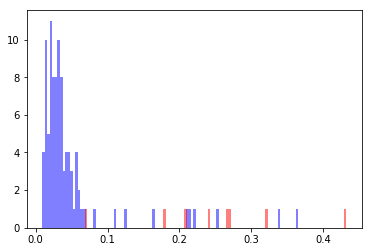

In [84]:
est_model = fuse_model(model_list)
est_neg_indices = np.where(est_val_Y == 0)
est_pos_indices = np.where(est_val_Y == 1)
est_scores = est_model.predict(est_val_X)[:, 1]
log(calc_metrics(est_val_Y, est_model.predict(est_val_X)))
plt.hist(est_scores[est_neg_indices], 100, label="NEG", alpha=0.5, color="blue")
plt.hist(est_scores[est_pos_indices], 100, label="LNM", alpha=0.5, color="red")

In [85]:
a = est_model.inp_models[0]

In [87]:
a.feature_importance()
a.feature_name() 

['脉管',
 'Unnamed:_0',
 '大小',
 '面积',
 '分级_0',
 '年龄',
 '深度',
 '部位_3',
 '分级_2',
 '出芽',
 '部位_4',
 '部位_0',
 '宽度',
 '低分化簇',
 '肉眼类型_1',
 '性别',
 '部位_2',
 '分级_3',
 '肉眼类型_0',
 '部位_5',
 '分级_1',
 '部位_1',
 '分级_4']

In [88]:
data_analysis = pd.DataFrame({"feature":a.feature_name(), "importance": a.feature_importance()})

In [50]:
data_analysis.to_excel(r"Y:/病理中心-结直肠癌患者淋巴结转移预测/project/Lymph_node_metastasisV2/analysis/data.xlsx",index=False)

In [89]:
## 绘制决策边界
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
#     ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

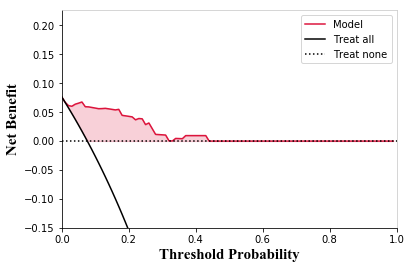

In [39]:
thresh_group = np.arange(0,1,0.01)
net_benefit_model = calculate_net_benefit_model(thresh_group, est_scores, est_val_Y)
net_benefit_all = calculate_net_benefit_all(thresh_group, est_val_Y)
fig, ax = plt.subplots()
ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
# fig.savefig('fig1.png', dpi = 300)
plt.show()

In [64]:
data_Decision_curve = pd.DataFrame({"thresh_group": thresh_group,"net_benefit_model":net_benefit_model,
                                   "net_benefit_all": net_benefit_all})

data_Decision_curve.to_excel(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\analysis\DC_AI.xlsx",
                            index=False)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
{
  est_feat_names[i]: vif(X_INP.values, X_INP.columns.get_loc(j))
  for i,j in enumerate(X_INP.columns)
}

D:\software\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'性别': 1.0834860117524021,
 '年龄': 1.0570774752618237,
 '大小': 1.1026292955349968,
 '宽度': 1.8631015219860332,
 '深度': 3.3202115666636285,
 '面积': 4.55508629497671,
 '脉管': 1.239213580305682,
 '出芽': 1.7942281212537146,
 '低分化簇': 1.8009771983811764,
 '部位_0': inf,
 '部位_1': inf,
 '部位_2': inf,
 '部位_3': inf,
 '部位_4': inf,
 '部位_5': inf,
 '肉眼类型_0': inf,
 '肉眼类型_1': inf,
 '分级_0': inf,
 '分级_1': inf,
 '分级_2': inf,
 '分级_3': inf,
 '分级_4': inf,
 'Unnamed: 0': 1.1646603604704795}

In [41]:
MIN_TPR_LIST = [0,0.01,0.02,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.95, 0.98, 0.99, 1.00]
log("= = = = =")
for MIN_TPR in MIN_TPR_LIST:
  THRs, thr_idx, TPRs, TNRs = get_thresh_meet_tpr(est_val_Y, est_scores, min_tpr=MIN_TPR, thr_eps=1e-3)
  log("TPR: {:.4f}, TNR: {:.4f}, THRESH: {:.4f}".format(TPRs[thr_idx], TNRs[thr_idx], THRs[thr_idx]))
  TN, FP, FN, TP = get_tn_fp_fn_tp(est_val_Y, est_scores, THRs[thr_idx])
  PPV, NPV = TP/(TP+FP), TN/(TN+FN)
  log("PPV: {:.4f}, NPV: {:.4f}".format(PPV, NPV))
  log("= = = = =")

2023-04-16 13:32:58]  = = = = =
2023-04-16 13:32:59]  TPR: 0.0000, TNR: 1.0000, THRESH: 0.9990
2023-04-16 13:32:59]  PPV: nan, NPV: 0.9238
2023-04-16 13:32:59]  = = = = =


D:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


2023-04-16 13:33:00]  TPR: 0.1250, TNR: 1.0000, THRESH: 0.4330
2023-04-16 13:33:00]  PPV: 1.0000, NPV: 0.9327
2023-04-16 13:33:00]  = = = = =
2023-04-16 13:33:01]  TPR: 0.1250, TNR: 1.0000, THRESH: 0.4330
2023-04-16 13:33:01]  PPV: 1.0000, NPV: 0.9327
2023-04-16 13:33:01]  = = = = =
2023-04-16 13:33:02]  TPR: 0.1250, TNR: 1.0000, THRESH: 0.4330
2023-04-16 13:33:02]  PPV: 1.0000, NPV: 0.9327
2023-04-16 13:33:02]  = = = = =
2023-04-16 13:33:03]  TPR: 0.2500, TNR: 0.9794, THRESH: 0.3180
2023-04-16 13:33:03]  PPV: 0.5000, NPV: 0.9406
2023-04-16 13:33:03]  = = = = =
2023-04-16 13:33:05]  TPR: 0.3750, TNR: 0.9794, THRESH: 0.2700
2023-04-16 13:33:05]  PPV: 0.6000, NPV: 0.9500
2023-04-16 13:33:05]  = = = = =
2023-04-16 13:33:06]  TPR: 0.5000, TNR: 0.9794, THRESH: 0.2690
2023-04-16 13:33:06]  PPV: 0.6667, NPV: 0.9596
2023-04-16 13:33:06]  = = = = =
2023-04-16 13:33:07]  TPR: 0.5000, TNR: 0.9794, THRESH: 0.2690
2023-04-16 13:33:07]  PPV: 0.6667, NPV: 0.9596
2023-04-16 13:33:07]  = = = = =
2023-0

In [90]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
import scipy.io

In [91]:
threshold_confusion = 0.17
print( "\nConfusion matrix:  Costum threshold (for positive) of " + str(threshold_confusion))
y_pred = np.empty((est_scores.shape[0]))
for i in range(est_scores.shape[0]):
    if est_scores[i] >= threshold_confusion:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
confusion = confusion_matrix(est_val_Y, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion)) != 0:
    accuracy = float(confusion[0, 0]+confusion[1, 1])/float(np.sum(confusion))
    s = float(confusion[1, 1]+confusion[1, 0])/float(np.sum(confusion))
    p = float(confusion[1, 1]+confusion[0, 1])/float(np.sum(confusion))
    inter = float(confusion[1, 1])/float(np.sum(confusion))
print("Global Accuracy: " + str(accuracy))
specificity = 0
if float(confusion[0, 0]+confusion[0, 1]) != 0:
    specificity = float(confusion[0, 0])/float(confusion[0, 0]+confusion[0, 1])
print("Specificity: " + str(specificity))
sensitivity = 0
if float(confusion[1, 1]+confusion[1, 0]) != 0:
    sensitivity = float(confusion[1, 1])/float(confusion[1, 1]+confusion[1, 0])
print("Sensitivity: " + str(sensitivity))
precision = 0
if float(confusion[1, 1]+confusion[0, 1]) != 0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " + str(precision))

recall = 0
if float(confusion[1, 1]+confusion[1, 0]) != 0:
    recall = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("recall: " + str(recall))
G = 0
G = float(np.sqrt(sensitivity * specificity))
print ("G score: " + str(G))

MCC = 0
MCC = float(inter-s*p)/float(np.sqrt(p*s*(1-s)*(1-p)))
print("MCC: " + str(MCC))

# Jaccard similarity index
jaccard_index = jaccard_score(est_val_Y, y_pred)
print("\nJaccard similarity score: " + str(jaccard_index))

# F1 score
F1_score = f1_score(est_val_Y, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " + str(F1_score))


Confusion matrix:  Costum threshold (for positive) of 0.17
[[91  6]
 [ 1  7]]
Global Accuracy: 0.9333333333333333
Specificity: 0.9381443298969072
Sensitivity: 0.875
Precision: 0.5384615384615384
recall: 0.875
G score: 0.906022234086887
MCC: 0.6549873445667473

Jaccard similarity score: 0.5

F1 score (F-measure): 0.6666666666666667


In [98]:
data_95ci_df = pd.DataFrame({"predict":est_scores,"label":est_val_Y})
data_95ci_df.to_excel(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\analysis_V2\Delong_test\AI.xlsx", index=False)


Area under the ROC curve: 0.961340206185567

Area under Precision-Recall curve: 0.6345238095238095


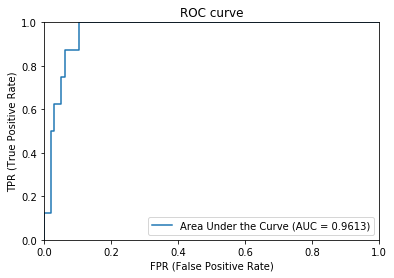

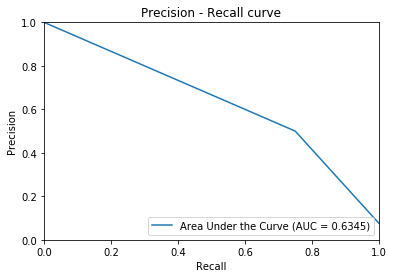

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(est_val_Y, est_scores)
AUC_ROC = roc_auc_score(est_val_Y, est_scores)
scipy.io.savemat(f"{save_dir_name}/roc.mat", {'fpr':fpr, 'tpr':tpr, 'th':thresholds, 'auc':AUC_ROC})
data_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'th':thresholds})
data_roc.to_excel(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\analysis\roc.xlsx", index=False)
np.save(f"{save_dir_name}/result.npy", np.asarray([est_val_Y, y_pred]))
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " + str(AUC_ROC))
roc_curve = plt.figure()
plt.plot(fpr, tpr, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.savefig(f"{save_dir_name}/AUC.png")

#pr
precision, recall, thresholds = precision_recall_curve(est_val_Y, est_scores>=threshold_confusion)
precision = np.fliplr([precision])[0]  # so the array is increasing (you won't get negative AUC) 作用是将数组在左右方向上翻转。
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision, recall)  # 梯形数值积分
print("\nArea under Precision-Recall curve: " + str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall, precision, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.savefig(f"{save_dir_name}/Pr.png")

0.14


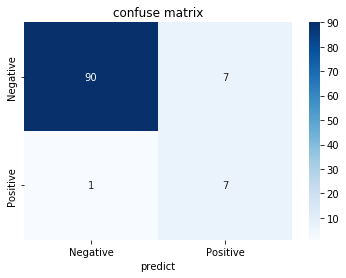

In [46]:
sns.heatmap(confusion_matrix(est_val_Y, est_scores>=threshold_confusion), annot=True, cmap="Blues", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("confuse matrix")
plt.xlabel("predict")
# plt.ylabel("True value")
print(threshold_confusion)

2023-04-16 13:33:19]  AUC: 0.9600515463917526


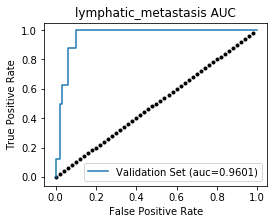

In [46]:
from sklearn.metrics import roc_curve
task_name1 = "lymphatic_metastasis"
est_val_Y = (est_val_Y > 0).astype("int")
FPRs, TPRs, THRs = roc_curve(est_val_Y, est_scores)
auc_score = roc_auc_score(est_val_Y, est_scores)
log(f"AUC: {auc_score}")
plt.figure(figsize=(4, 3))
plt.plot(FPRs, TPRs)
plt.title(f"{task_name1} AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([
  "Validation Set (auc={:.4f})".format(auc_score)
], loc="lower right")
plt.scatter(np.arange(0, 1, 0.02), np.arange(0, 1, 0.02), color="black", marker=".")

In [95]:
# 计算 AUC的95CI
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        # df.
        df.loc[:, 'y'] = y
        df.loc[:, 'pred'] = pred
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics
statistics = bootstrap_auc(est_val_Y, est_scores, [0,1])
print("均值:",np.mean(statistics,axis=1))
print("最大值:",np.max(statistics,axis=1))
print("最小值:",np.min(statistics,axis=1))

均值: [0.96065747 0.95995395]
最大值: [0.97292867 0.97482466]
最小值: [0.94977761 0.93523693]


In [1]:
88/105

0.8380952380952381

In [2]:
1123*0.618

694.014